## Imports

In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from EvaluationFunctions import performance_evaluation
import pipline

In [2]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
origin_dim = x_train.shape[1]

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## evaluation on MLPClassifier

In [3]:
def get_model():
    return MLPClassifier(solver="lbfgs")

### Performance evaluation - original data

Час навчання моделі - 31.17
Час затрачений для передбачення всіх x_test(10000) - 0.041 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



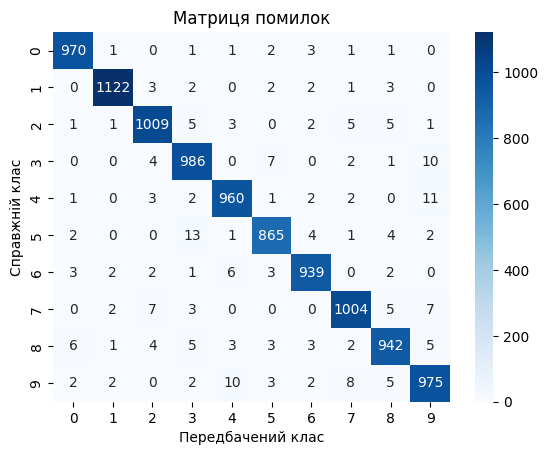

In [4]:
performance_evaluation(get_model(), x_train_flat, y_train, x_test_flat, y_test)

### Performance evaluation - reduced data - only AE

In [5]:
myPipe = pipline.myReducePipline()
x_train_ae,x_test_ae = myPipe.fit_ae_model(x_train,x_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0304
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0052
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0044
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0040
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0038
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0037
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0035
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0035
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0034
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0033
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання моделі - 36.46
Час затрачений для передбачення всіх x_test(10000) - 0.04 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



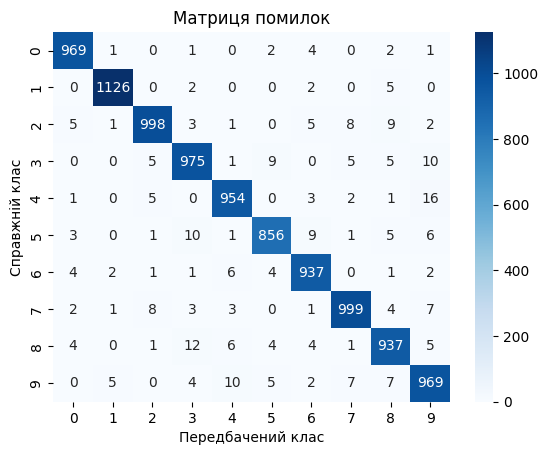

In [6]:
performance_evaluation(get_model(), x_train_ae, y_train, x_test_ae, y_test)

### Performance evaluation - reduced data - only SVD

Час навчання моделі - 16.85
Час затрачений для передбачення всіх x_test(10000) - 0.008 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 75.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



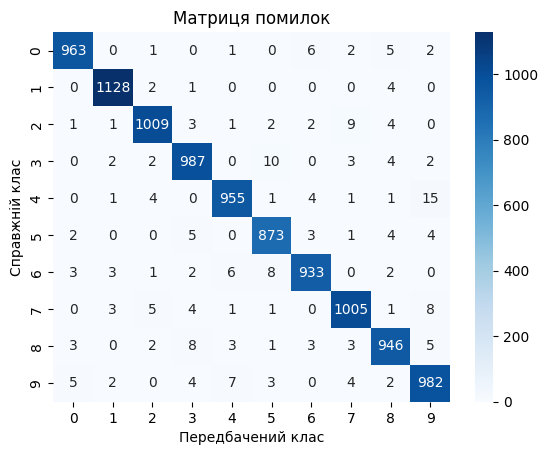

In [7]:
myPipeSvd = pipline.myReducePipline()
x_train_svd,x_test_svd = myPipeSvd.fit_svd_model(x_train_flat,x_test_flat)
performance_evaluation(get_model(), x_train_svd, y_train, x_test_svd, y_test)

### Performance evaluation - reduced data

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0314
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0052
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0045
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0041
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0039
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0037
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0036
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0035
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0034
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0034
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AE create + train time:  196.6718611717224  sec
SVD create + train time: 1.1603856086730957  sec


c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання моделі - 19.01
Час затрачений для передбачення всіх x_test(10000) - 0.009 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 75.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



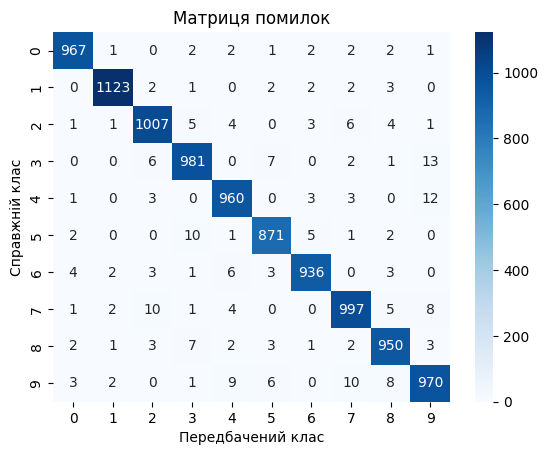

In [8]:
myPipe = pipline.myReducePipline()
x_train_reduced,x_test_reduced = myPipe.run_pipeline(x_train,x_test)
performance_evaluation(get_model(), x_train_reduced, y_train, x_test_reduced, y_test)

### print all data size

In [10]:
x1 = sys.getsizeof(x_train)
x2 = sys.getsizeof(x_train_ae)
x3 = sys.getsizeof(x_train_reduced)
print(f"Розмір оригінальних даних       - { x1 } байт")
print(f"Розмір після автоенкодера       - { x2 } байт ({x2/x1})")
print(f"Розмір після автоенкодера + SVD - { x3 } байт ({x3/x1})")

Розмір оригінальних даних       - 188160144 байт
Розмір після автоенкодера       - 128 байт (6.80271588227526e-07)
Розмір після автоенкодера + SVD - 19200128 байт (0.10204141850571713)


## visualisation

In [11]:
x_ae = x_train_ae.reshape(len(x_train_ae), origin_dim, -1)
x_ae.shape

(60000, 28, 28)

In [12]:
X_recovered = myPipeSvd.get_svd_inverse_transform(x_train_svd)
x_svd = X_recovered.reshape(len(X_recovered), origin_dim, -1)
x_svd.shape

(60000, 28, 28)

In [13]:
import math
x_svd_lat = x_train_svd.reshape(len(x_train_svd), int(math.sqrt(myPipeSvd.lat_dim_svd)), -1)
x_svd_lat.shape

(60000, 8, 10)

In [14]:
def plot_classes(x, y, title=''):
    unique_classes = np.unique(y)
    nrows, ncols = 1, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]

        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]

        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    print(title)
    plt.show()

origin


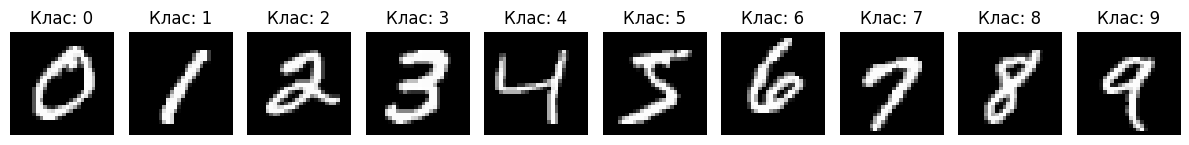

after AutoEncoder


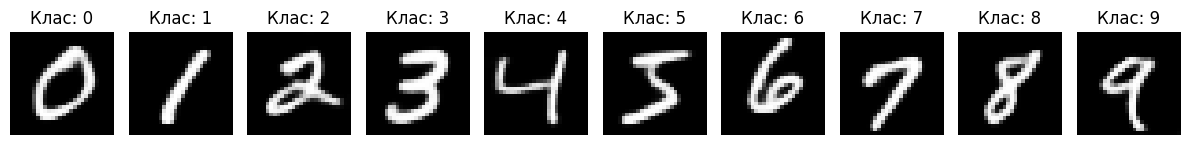

after AE+SVD (inversed)


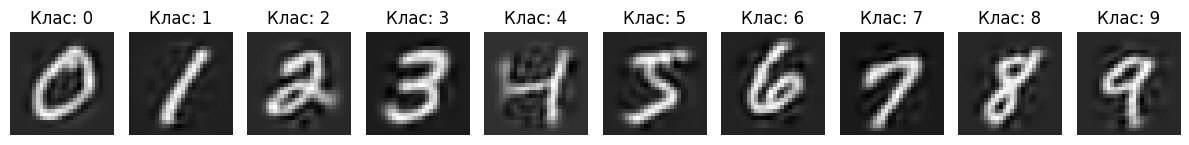

after AE+SVD (reduced)


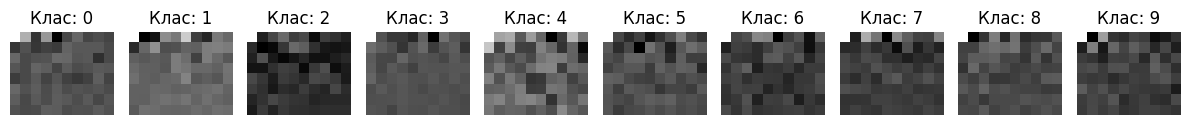

In [15]:
plot_classes(x_train,y_train, "origin")
plot_classes(x_ae,y_train, "after AutoEncoder")
plot_classes(x_svd,y_train, "after AE+SVD (inversed)") # after svd inverse
plot_classes(x_svd_lat,y_train, "after AE+SVD (reduced)") # clean svd